# Predicting Charged-Off Loans with LendingClub Data

## Table of Contents
1. [Introduction](#1.-Introduction)
2. [Data](#2.-Data)
3. [Target Variable](#3.-Target-Variable)
4. [Feature Selection](#4-Feature-Selection) 
    <br> &nbsp;&nbsp;&nbsp;&nbsp;4.1 [Remove Features with Excessive Missing Values](#41-remove-features-with-excessive-missing-values)
    <br> &nbsp;&nbsp;&nbsp;&nbsp;4.2 [Remove Duplicate Records](#42-remove-duplicate-records)
    <br> &nbsp;&nbsp;&nbsp;&nbsp;4.3 [Remove Weak Features](#43-remove-weak-features)
    <br> &nbsp;&nbsp;&nbsp;&nbsp;4.4 [Remove Highly Correlated Numerical Features](#44-remove-highly-correlated-numerical-features)
5. [Feature Engineering and Data Preparation](#5-feature-engineering-and-data-preparation) 
    <br> &nbsp;&nbsp;&nbsp;&nbsp;5.1 [Removing Outliers](#51-removing-outliers)
    <br> &nbsp;&nbsp;&nbsp;&nbsp;5.2 [Encoding Categorical Features](#52-encoding-categorical-features)
    <br> &nbsp;&nbsp;&nbsp;&nbsp;5.3 [Train/Test Split](#53-traintest-split)
    <br> &nbsp;&nbsp;&nbsp;&nbsp;5.4 [Standardizing Features](#54-standardizing-features)
6. [Modeling](#6-modeling) 
    <br> &nbsp;&nbsp;&nbsp;&nbsp;6.1 [CatBoost Method](#61-catboost-method)
    <br> &nbsp;&nbsp;&nbsp;&nbsp;6.2 [Random Forest Method](#62-random-forest-method)
    <br> &nbsp;&nbsp;&nbsp;&nbsp;6.3 [Lasso Method](#63-lasso-method)
    <br> &nbsp;&nbsp;&nbsp;&nbsp;6.4 [XGBoost Method](#64-xgboost-method)
    <br> &nbsp;&nbsp;&nbsp;&nbsp;6.5 [Linear Regressor Method](#65-linear-regressor-method)
    <br> &nbsp;&nbsp;&nbsp;&nbsp;6.6 [Voting Regressor Method](#66-voting-regressor-method)


In [287]:
# Uncomment this code to install the dependencies
# !pip install -r requirements.txt

In [288]:
# =======================
# Core Libraries
# =======================
import time
import warnings
from datetime import datetime

# =======================
# Data Manipulation & Visualization
# =======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Configure pandas and seaborn
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
%matplotlib inline

# =======================
# Model Persistence
# =======================
from joblib import dump, load

# =======================
# Scikit-learn: Models
# =======================
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso, LinearRegression
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# =======================
# Scikit-learn: Preprocessing & Pipelines
# =======================
from sklearn.preprocessing import StandardScaler

# =======================
# Scikit-learn: Model Selection & Evaluation
# =======================
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# =======================
# Miscellaneous
# =======================
warnings.filterwarnings("ignore")


## 1. Introduction

The goal of this notebook is to develop a predictive model using the publicly available [House Prices: Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques) dataset on Kaggle to estimate the final sale price of residential homes in Ames, Iowa. Specifically, we aim to predict the **SalePrice** of a house based on multiple features describing its physical attributes and location. This is a **regression problem**.

Our objective goes beyond building a predictive model—we also aim to evaluate and compare different machine learning algorithms, identify the most important features influencing house prices, and understand the effectiveness of various preprocessing and modeling techniques.

To accomplish this, we will evaluate several machine learning algorithms inspired by the framework from the paper ["Housing Market Prediction Problem using Different Machine Learning Algorithms" (arXiv:2006.10092)](https://arxiv.org/abs/2006.10092):

- **Linear Regression**
- **Lasso Regression**
- **Random Forest**
- **XGBoost**
- **CatBoost**
- **Voting Regressor (Ensemble)**

Each model will be assessed using standard regression metrics, including Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R² Score. In addition, we will incorporate residual plots and prediction-error visualizations to support model diagnostics and performance interpretation.

Ultimately, the selected model will serve as a reliable tool for predicting house prices and deriving insights from housing-related variables.


## 2. Data

The dataset used in this project is the [House Prices: Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data) dataset provided by Kaggle. It contains detailed records of 1,460 residential homes in Ames, Iowa, described by 79 explanatory variables covering aspects such as the building type, materials used, square footage, number of rooms, neighborhood, and year built.

In [289]:
df = pd.read_csv('data.csv',low_memory=True)

In [290]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [291]:
df.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
539,540,20,RL,NaN,11423,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,8,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,479.0,Gd,TA,PConc,Gd,TA,Av,GLQ,1358,Unf,0,223,1581,GasA,Ex,Y,SBrkr,1601,0,0,1601,1,0,2,0,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,670,TA,TA,Y,180,0,0,0,0,0,NaN,MnPrv,Shed,2000,5,2010,WD,Normal,272000
55,56,20,RL,100.0,10175,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1964,1964,Gable,CompShg,HdBoard,Plywood,BrkFace,272.0,TA,TA,CBlock,TA,TA,No,BLQ,490,Unf,0,935,1425,GasA,Gd,Y,SBrkr,1425,0,0,1425,0,0,2,0,3,1,TA,7,Typ,1,Gd,Attchd,1964.0,RFn,2,576,TA,TA,Y,0,0,0,407,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal,180500
633,634,20,RL,80.0,9250,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1954,2005,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,TA,TA,CBlock,TA,TA,No,BLQ,480,LwQ,468,108,1056,GasA,TA,Y,SBrkr,1056,0,0,1056,0,1,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1954.0,Unf,1,260,TA,TA,Y,390,0,0,0,0,0,NaN,NaN,NaN,0,7,2007,WD,Normal,139400
1282,1283,20,RL,61.0,8800,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,5,7,1977,2008,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,TA,TA,CBlock,Gd,TA,Mn,LwQ,532,Rec,144,364,1040,GasA,TA,Y,SBrkr,1040,0,0,1040,0,0,2,0,3,1,Gd,5,Typ,0,NaN,Detchd,1977.0,Unf,2,484,TA,TA,Y,0,0,0,0,288,0,NaN,NaN,NaN,0,9,2009,WD,Normal,150500
1076,1077,50,RL,60.0,10800,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,5,8,1936,1989,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,TA,TA,CBlock,Fa,TA,No,ALQ,626,Unf,0,170,796,GasA,Gd,Y,SBrkr,1096,370,0,1466,0,1,2,0,3,1,Gd,7,Min1,1,TA,Attchd,1950.0,Unf,2,566,TA,TA,Y,436,21,0,0,0,0,NaN,NaN,Shed,500,4,2006,WD,Normal,170000


Each row represents a house, and the target variable we aim to predict is `SalePrice`, the property's final sale price. The dataset includes both numerical and categorical features, making it well-suited for applying a range of regression models and preprocessing techniques.

The dataset is small and clean enough to be used directly without requiring significant downsampling or compression, and can be commonly used for benchmarking regression algorithms in academic and practical machine learning tasks.

The dataset contains a mix of numerical and categorical variables, along with several missing values. Given the relatively high dimensionality of the data (79 features), we will begin the preprocessing phase by identifying and removing features that are irrelevant, redundant, or highly collinear, as they may not contribute meaningfully to the model’s predictive power.

## 3. Target Variable

The variable we aim to predict is **`SalePrice`**, which represents the final sale price of each house. Let us explore the values of this variable first.

In [292]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [293]:
def plot_distribution(df, column, xlabel='Value', ylabel='Frequency', title=None, bins=30):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True, bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title or f'Distribution of {column}')
    plt.grid(True)
    plt.show()


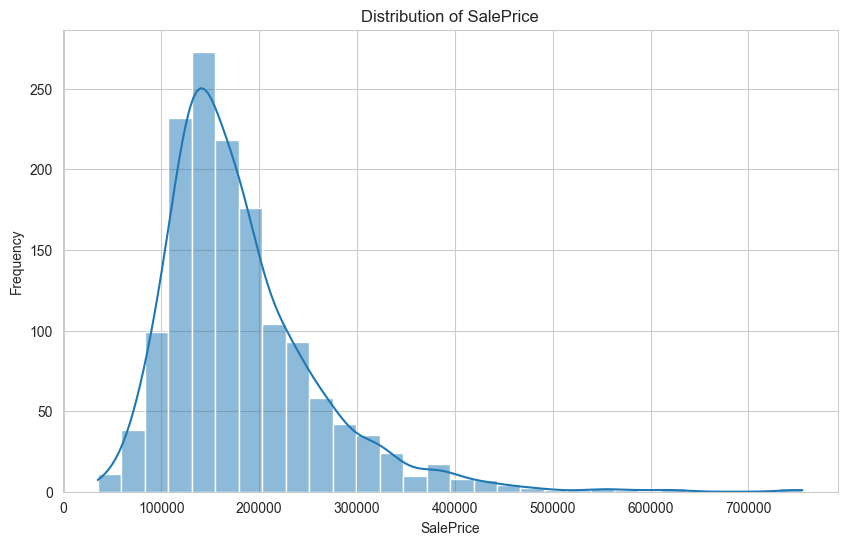

In [294]:
plot_distribution(df, 'SalePrice', xlabel='SalePrice', ylabel='Frequency')

As shown in the histogram above, the distribution of **SalePrice** is **right-skewed**, meaning that most houses in the dataset are sold at moderate prices, while a smaller number of properties are sold at significantly higher prices. This skewness can negatively impact the performance of regression models, particularly those that assume normally distributed residuals (e.g., linear regression).

To address this issue and stabilize variance, we will apply a **log transformation** to the `SalePrice` variable. This helps to reduce skewness, improve model performance, and provide more normally distributed prediction errors.

In [295]:
def log_transform_features(df, features):
    """
    Apply natural log (log1p) transformation to specified features without modifying the original DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        features (list): List of feature names to log-transform.

    Returns:
        pd.DataFrame: A new DataFrame with log-transformed features.
    """
    df_copy = df.copy()
    for feature in features:
        df_copy[feature] = np.log1p(df_copy[feature]) 
    return df_copy


In [296]:
df = log_transform_features(df, ["SalePrice"])

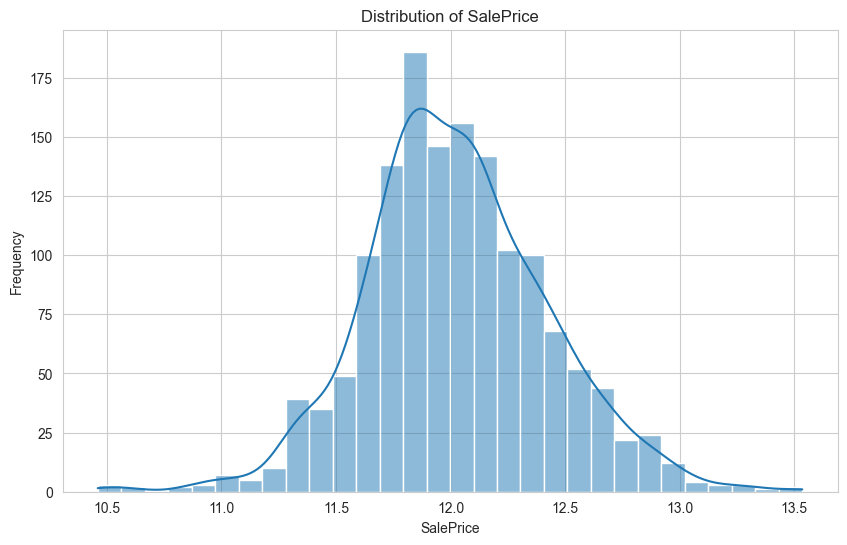

In [297]:
plot_distribution(df, 'SalePrice', xlabel='SalePrice', ylabel='Frequency')

After applying a log transformation to the `SalePrice` variable, we observe that its distribution becomes much more symmetric and closer to a normal (Gaussian) distribution. This is an important preprocessing step for many regression models—especially linear models—which assume normally distributed residuals and benefit from homoscedasticity.

The log transformation helps to:
- Reduce the impact of extreme values or outliers
- Stabilize the variance across the dataset
- Improve the overall fit and predictive performance of models

We will use the log-transformed `SalePrice` as the target variable for training, and reverse the transformation (exponentiate the predictions) when evaluating final model performance in the original price scale.

## 4. Feature Selection

The original dataset contains 80 features, but not all of them are relevant or appropriate for our predictive modeling task. To ensure the model is both accurate and efficient, we need to reduce dimensionality by selecting only the most informative features.

Detailed definitions of all columns are available in the `data_description.txt` file provided with the dataset.

In this section, we will apply the following feature selection criteria:

- Remove duplicate records to avoid redundant information that could bias the model
- Remove features with excessive missing values (e.g., more than 50% missing)
- Convert string-based categorical features into numerical format using appropriate encodings
- Eliminate features with low or zero variance, as they contribute little to predictive performance
- Identify and remove highly correlated features to reduce multicollinearity (e.g., more than 0.7)
- Create new combined features (e.g., total square footage, total bathrooms) that may better capture property characteristics
- Prioritize features that show strong correlation with the target variable (`SalePrice`)

These steps will help improve model performance, reduce overfitting, and support more interpretable results.

### 4.1 Remove Features with Excessive Missing Values

To better understand the extent of missing data in the dataset, we will define a utility function that displays a summary table. This table will include each feature's total number of missing values, the percentage of missing values, and the corresponding data type. This will help us identify and remove features that exceed our predefined threshold for missing data.

In [298]:
def missing_values_table(df):
    # Total missing values
    missing_values_total = df.isnull().sum()
    # Percentage of missing values
    missing_values_percentage = missing_values_total / len(df) * 100
    # Data types
    missing_values_type = df.dtypes

    # Make a table with the results
    table = pd.concat(
        [missing_values_total, missing_values_percentage, missing_values_type],
        axis=1
    )

    # Rename the columns
    table.columns = ['Missing Values', '% of Total Values', 'Data Type']

    # Filter out columns with no missing values and sort
    table = table[table['Missing Values'] > 0].sort_values('% of Total Values', ascending=False).round(1)

    # Print summary
    print(f"The dataframe has {df.shape[1]} columns and {table.shape[0]} columns that have missing values.")

    return table

In [299]:
missing_values_table(df)

The dataframe has 81 columns and 19 columns that have missing values.


,Missing Values,% of Total Values,Data Type
PoolQC,1453,99.5,object
MiscFeature,1406,96.3,object
Alley,1369,93.8,object
Fence,1179,80.8,object
MasVnrType,872,59.7,object
FireplaceQu,690,47.3,object
LotFrontage,259,17.7,float64
GarageType,81,5.5,object
GarageYrBlt,81,5.5,float64
GarageFinish,81,5.5,object


We set a threshold of 50% missing values, meaning that any feature with more than 50% of its values missing will be considered for removal, as it is unlikely to contribute meaningfully to the model.

In [300]:
missing_percent = df.isnull().mean()
high_missing = missing_percent[missing_percent > 0.5]
drop_list = sorted(high_missing.index)
print(drop_list)

['Alley', 'Fence', 'MasVnrType', 'MiscFeature', 'PoolQC']


In [301]:
len(drop_list)

5

In [302]:
def drop_cols(cols):
    df.drop(labels=cols, axis=1, inplace=True)

In [303]:
drop_cols(drop_list)

In [304]:
df.shape

(1460, 76)

### 4.2 Remove Duplicate Records

Before proceeding with feature engineering and model training, it's important to ensure that the dataset does not contain any fully duplicated records. Duplicate entries can lead to biased learning, as the model may overfit repeated patterns and fail to generalize well to unseen data.

In this step, we will identify and remove any rows that are exact duplicates across all columns, including the target variable `SalePrice`. While such cases are rare in well-curated datasets, this step aligns with best practices and helps ensure the integrity of the training data.

In [305]:
duplicate_mask = df.duplicated()
num_duplicates = duplicate_mask.sum()
print(f"Number of fully duplicated rows: {num_duplicates}")

Number of fully duplicated rows: 0


### 4.3 Remove Weak Features

With 75 features remaining in the dataset, dimensionality reduction becomes essential to improve both model performance and training efficiency. Rather than manually inspecting each feature, we apply a data-driven strategy to automatically eliminate those that are unlikely to provide predictive value for the target variable, `SalePrice`.

We use different techniques for numerical and categorical features:

- **Low Variance Filter (Numerical)**: Numerical features with very little variation across observations are unlikely to be useful in differentiating between house prices and can be removed without loss of information.

- **Weak Correlation with Target (Numerical)**: We compute the absolute Pearson correlation between each numerical feature and `SalePrice`. Features with very weak correlation (e.g., less than 0.05) are excluded, as they likely do not contribute meaningful signal.

- **Low Mutual Information with Target (Categorical)**: For categorical features, we apply mutual information analysis to estimate how much each feature contributes to explaining the variability of `SalePrice`. Features with very low mutual information scores are considered uninformative and removed.

These steps help retain the most informative variables while reducing noise and the risk of overfitting. A deeper examination of feature intercorrelations will follow in [Section 4.4](#44-remove-highly-correlated-numerical-features).

In [306]:
# Remove low-variance numerical features
numerical_features = df.select_dtypes(exclude=['object']).drop(columns='SalePrice')
selector = VarianceThreshold(threshold=0.1)
selector.fit(numerical_features)
low_variance_cols = numerical_features.columns[~selector.get_support()].tolist()
print(f"Low-variance features: {low_variance_cols}")

Low-variance features: ['BsmtHalfBath', 'KitchenAbvGr']


In [307]:
drop_cols(low_variance_cols)

In [308]:
# Remove numericals features with weak correlation to SalePrice
numerical_features = df.select_dtypes(exclude=['object']).drop(columns='SalePrice')
correlation_scores = df[numerical_features.columns].corrwith(df['SalePrice']).abs()
low_corr_cols = correlation_scores[correlation_scores < 0.5].index.tolist()
print(f"Weak correlated features: {low_corr_cols}")

Weak correlated features: ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'HalfBath', 'BedroomAbvGr', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [309]:
drop_cols(low_corr_cols)

In [310]:
#  Remove categorical features with low mutual information
categorical_features = df.select_dtypes(include='object').copy()

# Encode each categorical feature with LabelEncoder
le_dict = {}
for col in categorical_features.columns:
    le = LabelEncoder()
    categorical_features[col] = le.fit_transform(categorical_features[col].astype(str))
    le_dict[col] = le
    
# Compute mutual information with target
mi_scores = mutual_info_regression(categorical_features, df['SalePrice'], random_state=42)
mi_series = pd.Series(mi_scores, index=categorical_features.columns).sort_values()

# Set threshold and drop weak features
mi_threshold = 0.01
low_mi_cols = mi_series[mi_series < mi_threshold].index.tolist()
print(f"Low mutual information features: {low_mi_cols}")

Low mutual information features: ['Street', 'Utilities', 'Functional', 'LandSlope', 'Condition2', 'RoofMatl']


In [311]:
drop_cols(low_mi_cols)

In [312]:
df.shape

(1460, 44)

### 4.4 Remove Highly Correlated Numerical Features

Multicollinearity occurs when two or more numerical features are highly correlated with each other. This can lead to instability in model coefficients, redundancy in the data, and diminished model interpretability — particularly for linear models.

In this section, we compute the Pearson correlation matrix for all remaining numerical features (excluding the target) and identify pairs with high correlation (e.g., above 0.9). From each pair, we retain only one feature to reduce redundancy while preserving predictive signal.

This step helps simplify the model, improve training efficiency, and reduce the risk of overfitting due to duplicated information.

In [313]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 44 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1460 non-null   object 
 1   LotShape       1460 non-null   object 
 2   LandContour    1460 non-null   object 
 3   LotConfig      1460 non-null   object 
 4   Neighborhood   1460 non-null   object 
 5   Condition1     1460 non-null   object 
 6   BldgType       1460 non-null   object 
 7   HouseStyle     1460 non-null   object 
 8   OverallQual    1460 non-null   int64  
 9   YearBuilt      1460 non-null   int64  
 10  YearRemodAdd   1460 non-null   int64  
 11  RoofStyle      1460 non-null   object 
 12  Exterior1st    1460 non-null   object 
 13  Exterior2nd    1460 non-null   object 
 14  ExterQual      1460 non-null   object 
 15  ExterCond      1460 non-null   object 
 16  Foundation     1460 non-null   object 
 17  BsmtQual       1423 non-null   object 
 18  BsmtCond

In [314]:
numerical_features = df.select_dtypes(exclude=['object']).drop(columns='SalePrice').columns
numerical_features

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
       'GarageArea'],
      dtype='object')

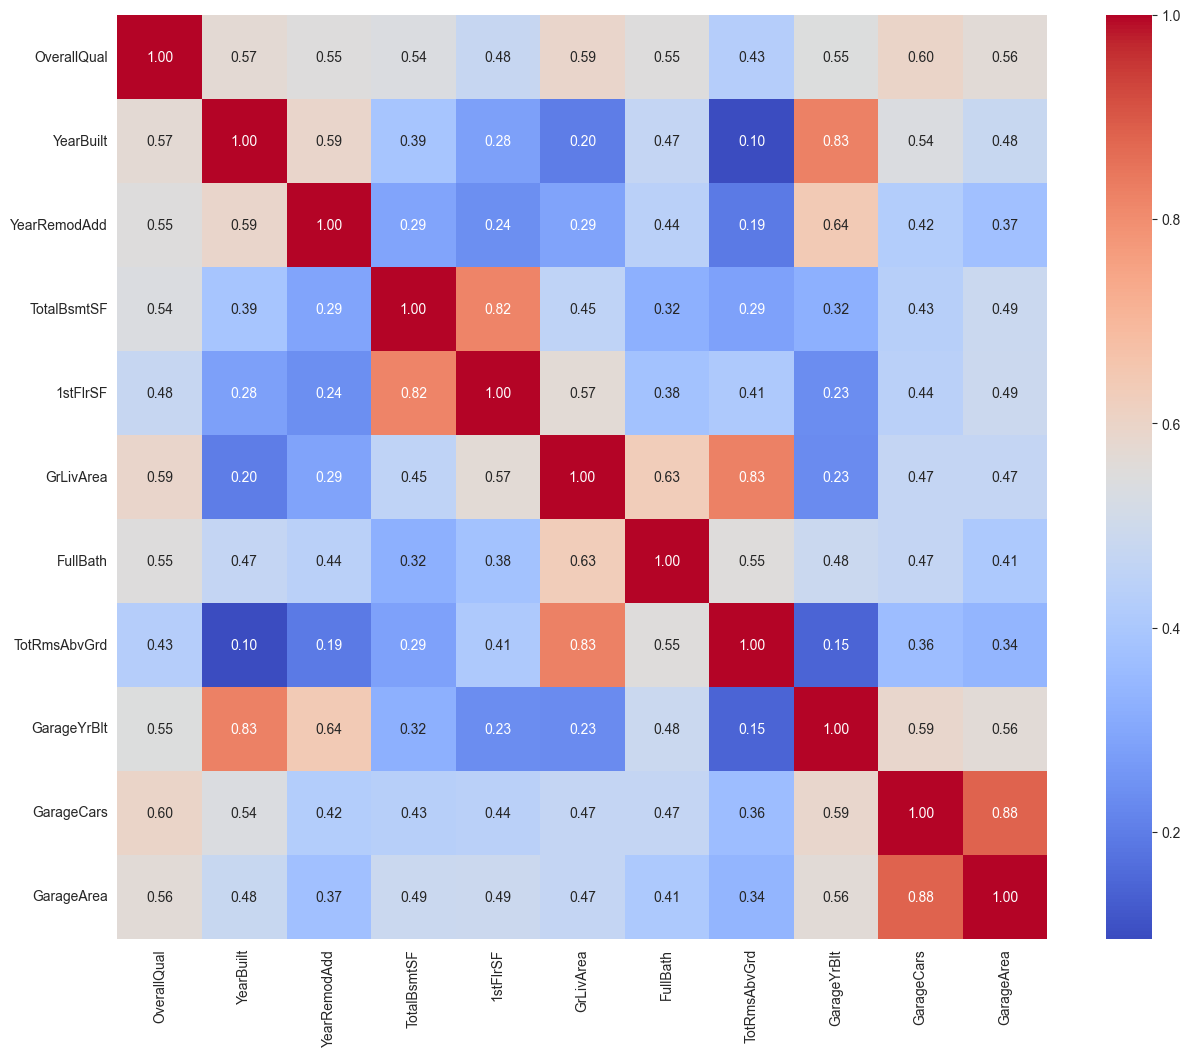

In [315]:
fig, ax = plt.subplots(figsize=(15,12))
cm_df = sns.heatmap(df[numerical_features].corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)

From the correlation heatmap above, we observe several pairs of numerical features that are strongly correlated with each other (correlation coefficient > 0.7). Such high correlation indicates redundancy, where two features provide overlapping information. Including both in the model can lead to multicollinearity, inflated variance in coefficient estimates, and overfitting — especially for linear models.

To address this, we identify and consider removing one feature from each highly correlated pair. The decision is based on domain relevance, interpretability, and strength of correlation with the target variable `SalePrice`.

Below are the most notable highly correlated feature pairs:

| Feature 1       | Feature 2       | Correlation |
|-----------------|-----------------|-------------|
| `TotalBsmtSF`   | `1stFlrSF`      | 0.82        |
| `GarageCars`    | `GarageArea`    | 0.88        |
| `GrLivArea`     | `TotRmsAbvGrd`  | 0.83        |
| `YearBuilt`     | `GarageYrBlt`   | 0.83        |

For each pair, we retain the feature that has a stronger correlation with `SalePrice`.

In [316]:
def correlated_features_to_drop(df, correlated_pairs, target='SalePrice'):
    features_to_drop = []
    
    for f1, f2 in correlated_pairs:
        corr1 = abs(df[[f1, target]].corr().iloc[0, 1])
        corr2 = abs(df[[f2, target]].corr().iloc[0, 1])
        
        drop = f1 if corr1 < corr2 else f2
        print(f"{f1} vs {f2} → dropping '{drop}' "
              f"(corr: {corr1:.2f} vs {corr2:.2f})")
        features_to_drop.append(drop)
    
    return features_to_drop

In [317]:
correlated_pairs = [
    ('TotalBsmtSF', '1stFlrSF'),
    ('GarageCars', 'GarageArea'),
    ('GrLivArea', 'TotRmsAbvGrd'),
    ('YearBuilt', 'GarageYrBlt')
]
features_to_drop = correlated_features_to_drop(df, correlated_pairs)

TotalBsmtSF vs 1stFlrSF → dropping '1stFlrSF' (corr: 0.61 vs 0.60)
GarageCars vs GarageArea → dropping 'GarageArea' (corr: 0.68 vs 0.65)
GrLivArea vs TotRmsAbvGrd → dropping 'TotRmsAbvGrd' (corr: 0.70 vs 0.53)
YearBuilt vs GarageYrBlt → dropping 'GarageYrBlt' (corr: 0.59 vs 0.54)


In [318]:
drop_cols(features_to_drop)

## 5. Feature Engineering and Data Preparation

### 5.1 Removing outliers

To identify and handle outliers, we will apply two common techniques: the **Modified Z-Score method** and the **Interquartile Range (IQR) method**. These methods are appropriate for continuous numerical variables and help detect extreme values that may unduly influence model training. It is important to note that these techniques are not applicable to categorical variables.

In [319]:
def outliers_modified_z_score(dataframe, features):
    """
    Computes the percentage of outliers in each feature using the Modified Z-Score method.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame.
        features (list): List of continuous feature names to evaluate.

    Returns:
        List of tuples: (feature name, percentage of outliers)
    """
    threshold = 3.5
    results = []

    for col in features:
        median = np.median(dataframe[col])
        mad = np.median(np.abs(dataframe[col] - median))

        if mad == 0:
            continue  # Skip constant features

        z_scores = 0.6745 * (dataframe[col] - median) / mad
        outlier_mask = np.abs(z_scores) > threshold
        outlier_count = outlier_mask.sum()
        total_count = dataframe[col].shape[0]

        percentage = round(outlier_count / total_count * 100, 2)
        results.append((col, percentage))

    return results


In [320]:
def outliers_iqr(dataframe, features):
    """
    Computes the percentage of outliers in each feature using the IQR (Tukey) method.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame.
        features (list): List of continuous feature names to evaluate.

    Returns:
        List of tuples: (feature name, percentage of outliers)
    """
    results = []

    for col in features:
        col_data = dataframe[col].dropna()
        q1, q3 = np.percentile(col_data, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        outlier_mask = (col_data < lower_bound) | (col_data > upper_bound)
        outlier_count = outlier_mask.sum()
        total_count = dataframe[col].shape[0]

        percentage = round(outlier_count / total_count * 100, 2)
        results.append((col, percentage))

    return results


In [321]:
numerical_features = df.select_dtypes(exclude=['object']).drop(columns='SalePrice').columns
numerical_features

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'GrLivArea',
       'FullBath', 'GarageCars'],
      dtype='object')

In [322]:
outliers_modified_z_score(df, numerical_features)

[('OverallQual', np.float64(0.0)),
 ('YearBuilt', np.float64(0.0)),
 ('YearRemodAdd', np.float64(0.0)),
 ('TotalBsmtSF', np.float64(0.96)),
 ('GrLivArea', np.float64(0.96))]

In [323]:
outliers_iqr(df, numerical_features)

[('OverallQual', np.float64(0.14)),
 ('YearBuilt', np.float64(0.48)),
 ('YearRemodAdd', np.float64(0.0)),
 ('TotalBsmtSF', np.float64(4.18)),
 ('GrLivArea', np.float64(2.12)),
 ('FullBath', np.float64(0.0)),
 ('GarageCars', np.float64(0.34))]

According to the outlier analysis, we found that `GrLivArea` and `TotalBsmtSF` include a few very large values — exceptionally spacious houses or basements — which skew the distribution significantly. To address this, we will apply a log transformation to compress their scale and reduce the influence of those extremes. Similarly, `GarageCars` has rare high values, such as homes with four or more garage spaces, that are not representative of the majority. These will be handled using winsorization to cap outliers at a reasonable upper bound. Although `YearBuilt` includes some very old or very new homes, the variation isn't severe enough to require immediate action, though we may revisit it later during model refinement. For the remaining features like `OverallQual`, `YearRemodAdd`, and `FullBath`, their distributions appear clean and balanced, so no outlier treatment is necessary.

To better understand the impact of outliers and verify our cleaning approach, we will visualize each feature before and after applying the appropriate transformations.

In [324]:
def plot_feature(df, col_name, full_name, target='SalePrice'):
    """
    Plot distribution of a continuous feature and its relationship with the target variable.

    Parameters:
    - df: pd.DataFrame, the dataset
    - col_name: str, name of the feature column
    - full_name: str, display name for titles and axes
    - target: str, name of the target variable (default: 'SalePrice')
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

    # Plot 1: Distribution of the feature
    sns.histplot(df[col_name].dropna(), kde=True, bins=30, ax=ax1, color="#5975A4")
    ax1.set_title(f"Distribution of {full_name}")
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Frequency')

    # Plot 2: Scatter plot with target
    sns.scatterplot(x=col_name, y=target, data=df, ax=ax2, alpha=0.6, color="#CC8963")
    ax2.set_title(f"{target} vs {full_name}")
    ax2.set_xlabel(full_name)
    ax2.set_ylabel(target)

    plt.tight_layout()
    plt.show()

    # Optional KDE of feature
    plt.figure(figsize=(10, 3))
    sns.kdeplot(data=df, x=col_name, fill=True, color="#5975A4")
    plt.title(f"KDE of {full_name}")
    plt.xlabel(full_name)
    plt.tight_layout()
    plt.show()

#### `GrLivArea`

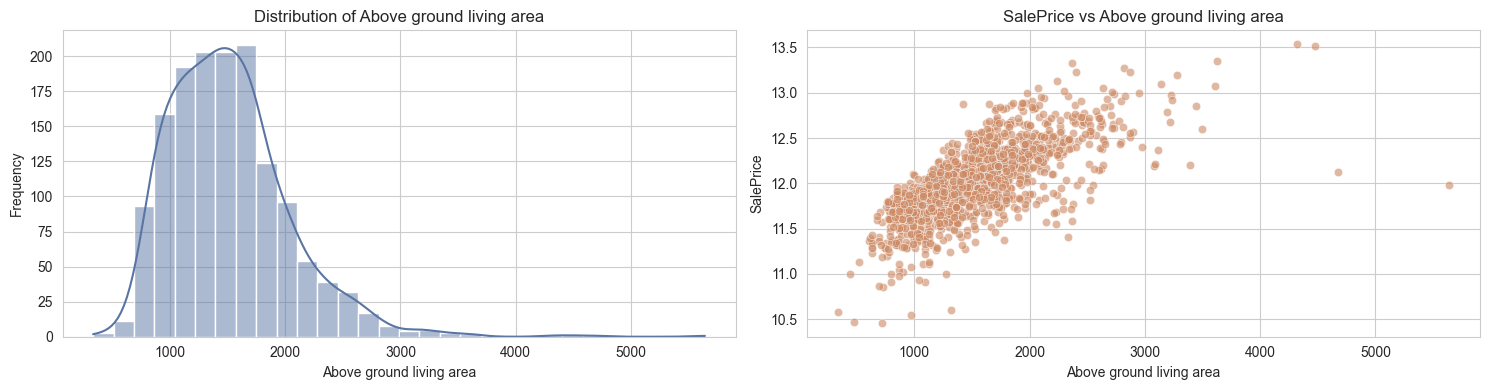

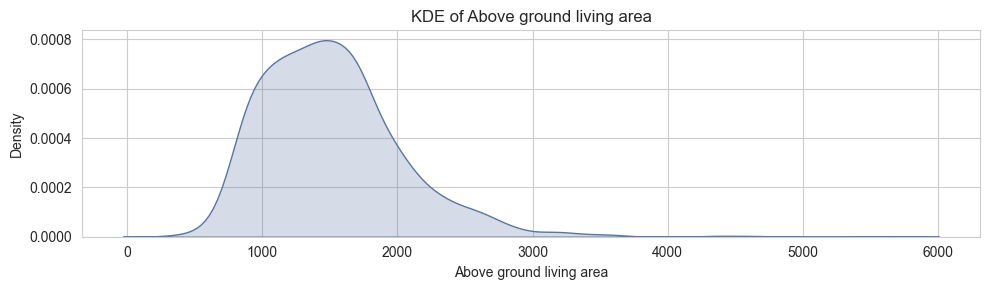

In [325]:
plot_feature(df, 'GrLivArea', 'Above ground living area')

In [326]:
df = log_transform_features(df, ["GrLivArea"])

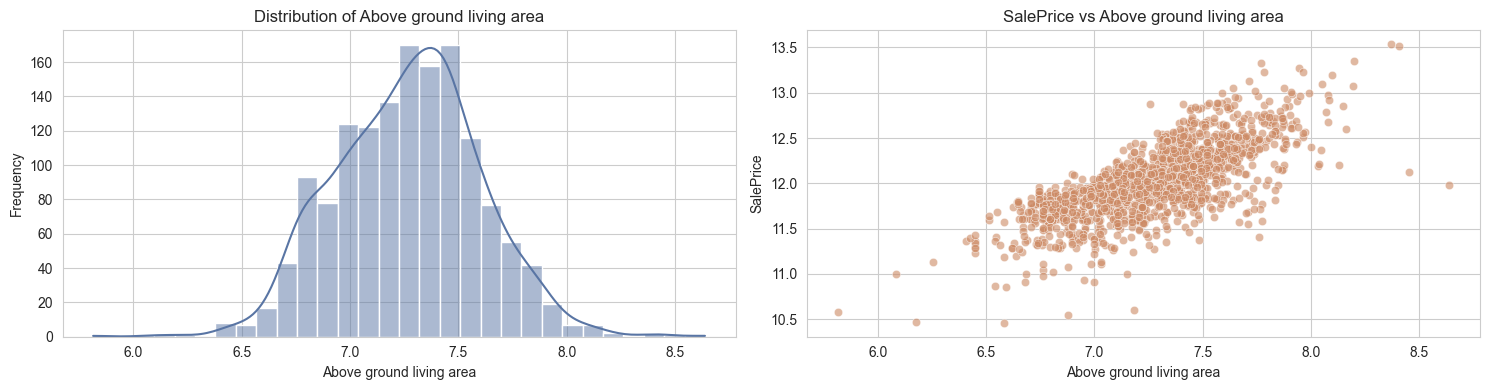

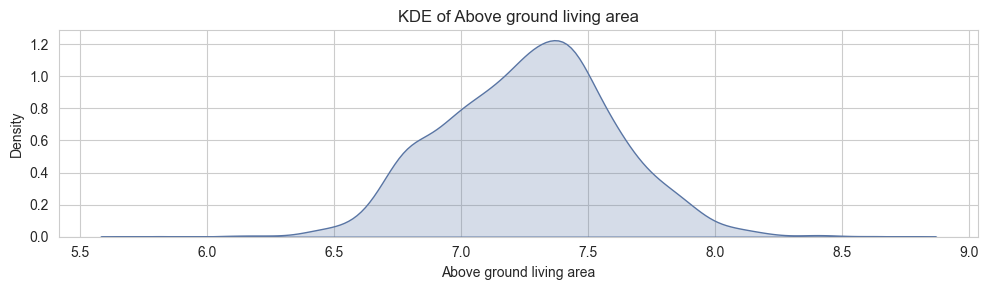

In [327]:
plot_feature(df, 'GrLivArea', 'Above ground living area')

In [328]:
outliers_modified_z_score(df, ["GrLivArea"])

[('GrLivArea', np.float64(0.27))]

In [329]:
outliers_iqr(df, ["GrLivArea"])

[('GrLivArea', np.float64(0.68))]

#### ```TotalBsmtSF```

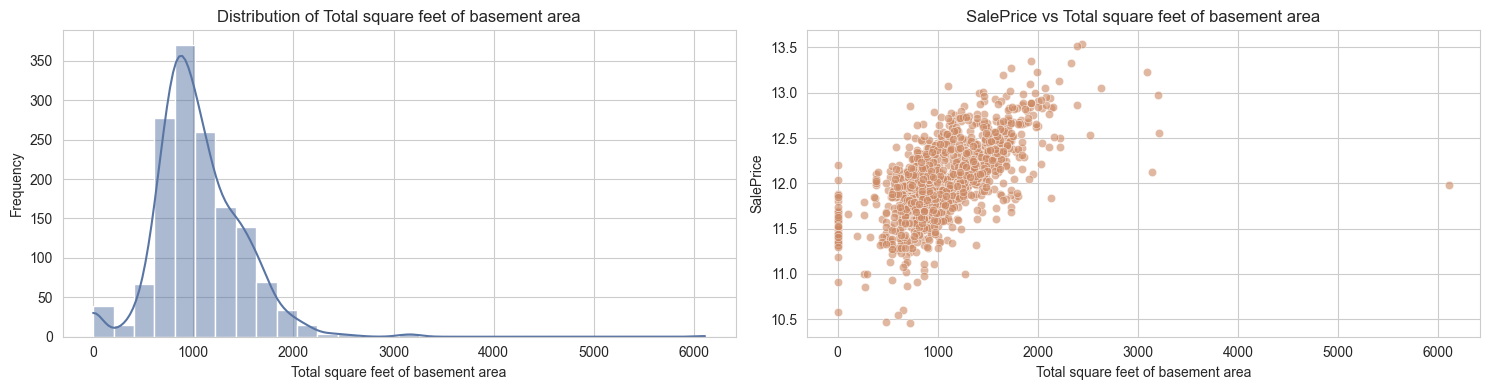

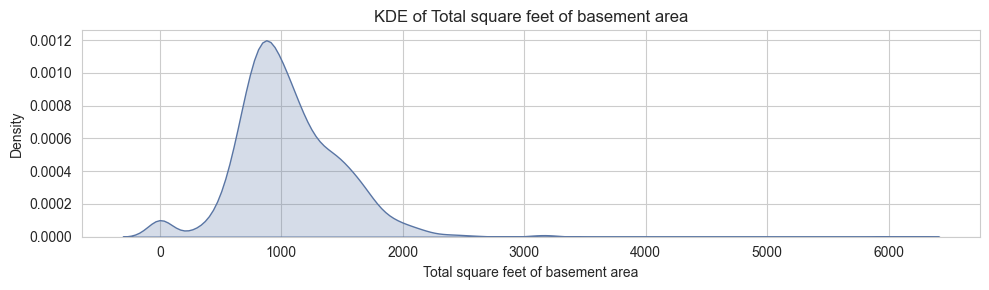

In [330]:
plot_feature(df, 'TotalBsmtSF', 'Total square feet of basement area')

In [331]:
df = log_transform_features(df, ["TotalBsmtSF"])

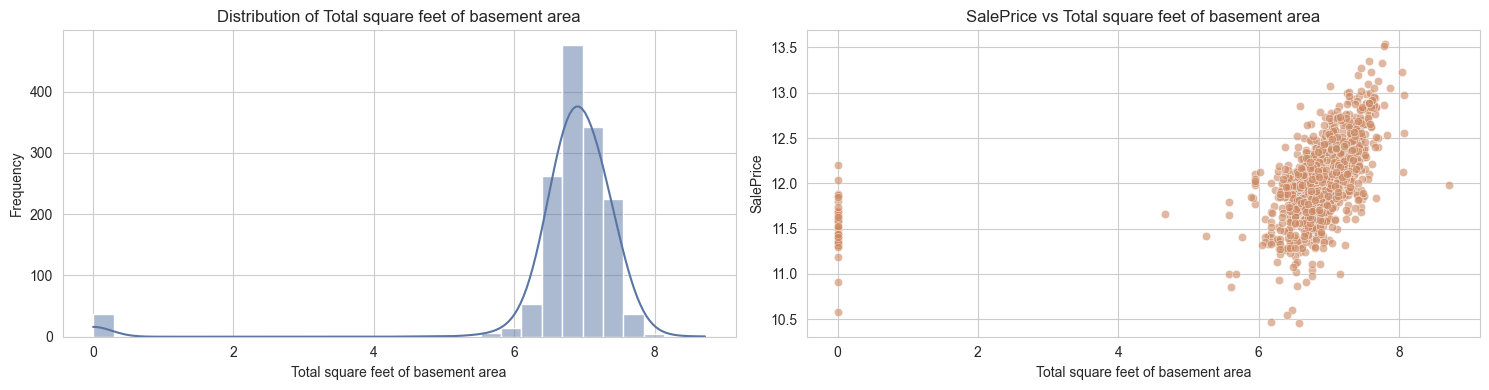

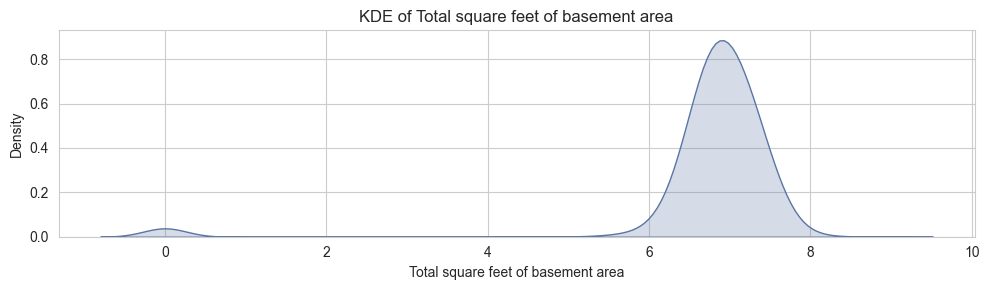

In [332]:
plot_feature(df, 'TotalBsmtSF', 'Total square feet of basement area')

In [333]:
outliers_modified_z_score(df, ["TotalBsmtSF"])

[('TotalBsmtSF', np.float64(3.01))]

In [334]:
outliers_iqr(df, ["TotalBsmtSF"])

[('TotalBsmtSF', np.float64(3.56))]

#### ```GarageCars```

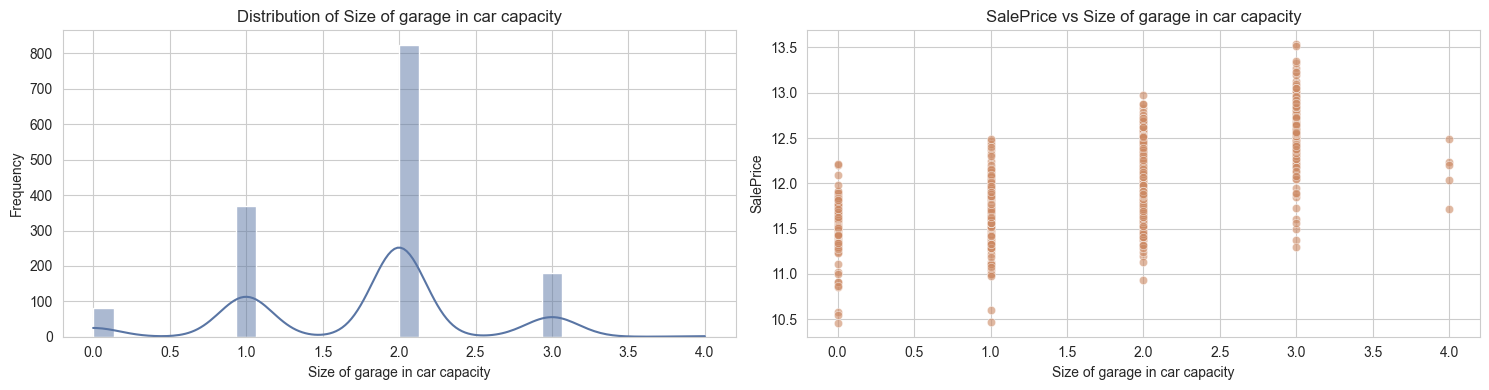

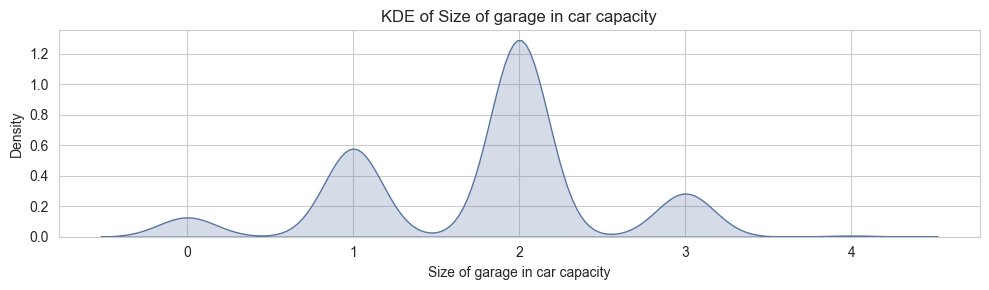

In [335]:
plot_feature(df, 'GarageCars', 'Size of garage in car capacity')

In [336]:
def winsorize_features(df, features, lower_quantile=0.01, upper_quantile=0.99):
    """
    Apply winsorization by clipping the values of specified features at given quantiles,
    without modifying the original DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        features (list): List of feature names to winsorize.
        lower_quantile (float): Lower quantile for clipping.
        upper_quantile (float): Upper quantile for clipping.

    Returns:
        pd.DataFrame: A new DataFrame with winsorized features.
    """
    df_copy = df.copy()

    for feature in features:
        lower = df_copy[feature].quantile(lower_quantile)
        upper = df_copy[feature].quantile(upper_quantile)
        df_copy[feature] = df_copy[feature].clip(lower=lower, upper=upper)

    return df_copy


In [337]:
df = winsorize_features(df, ['GarageCars'])

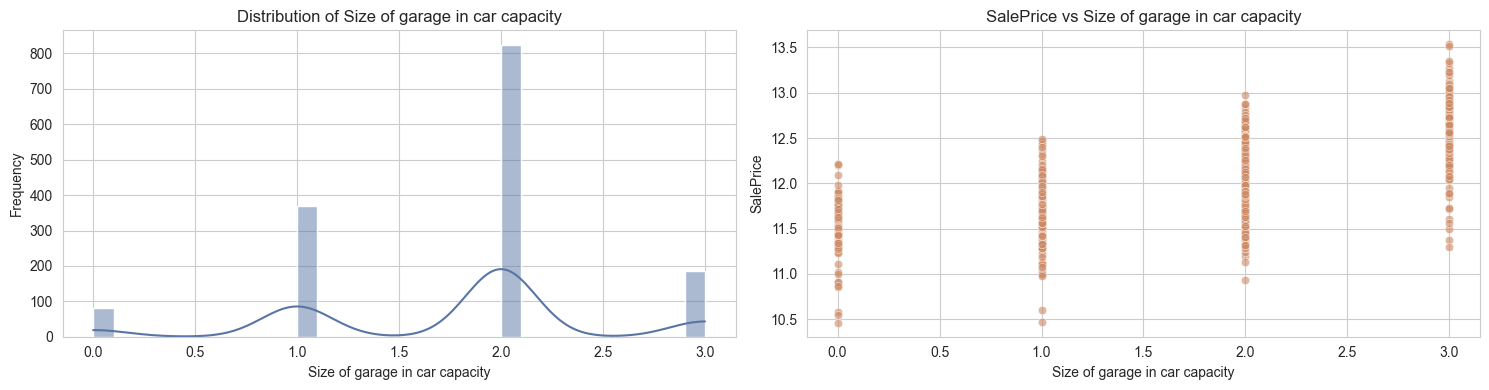

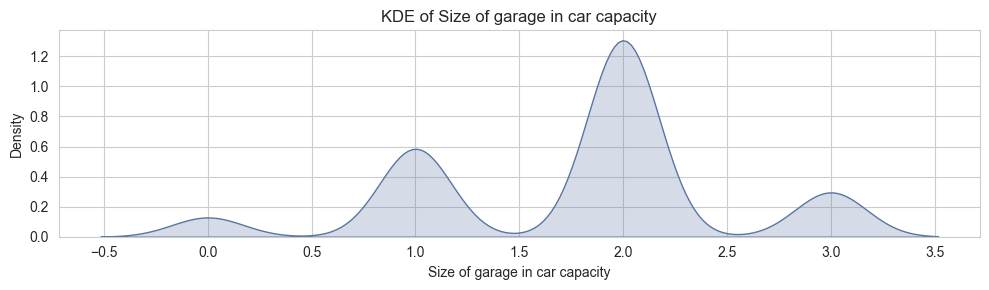

In [338]:
plot_feature(df, 'GarageCars', 'Size of garage in car capacity')

In [339]:
outliers_modified_z_score(df, ["GarageCars"])

[]

In [340]:
outliers_iqr(df, ["GarageCars"])

[('GarageCars', np.float64(0.0))]

### 5.2 Encoding Categorical Features

To prepare categorical variables for modeling, we need to convert them into numerical format. However, not all categorical features should be treated the same. Features that represent **unordered categories** (such as neighborhoods or exterior materials) are best handled using **one-hot encoding**, which creates binary indicator variables for each category. On the other hand, features that reflect an **inherent order or quality ranking** (e.g., Excellent > Good > Fair) are more appropriate for **label encoding**, which preserves their ordinal nature by assigning increasing integer values.

Based on the dataset’s documentation and the meaning of each feature, we apply the following encoding strategies:

- **Label Encoding** (ordinal features): `ExterQual`, `ExterCond`, `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`, `HeatingQC`, `KitchenQual`, `FireplaceQu`, `GarageFinish`, `GarageQual`, `GarageCond`

- **One-Hot Encoding** (nominal features): `MSZoning`, `LotShape`, `LandContour`, `LotConfig`, `Neighborhood`, `Condition1`, `BldgType`, `HouseStyle`, `RoofStyle`, `Exterior1st`, `Exterior2nd`, `Foundation`, `Heating`, `CentralAir`, `Electrical`, `GarageType`, `PavedDrive`, `SaleType`, `SaleCondition`

This distinction helps preserve the semantic meaning of each variable and ensures compatibility with machine learning models that may be sensitive to numeric ordering.


In [341]:
label_encoding_cols = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
    'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond'
]

In [342]:
# Label Encoding
label_encoders = {}

for col in label_encoding_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [343]:
one_hot_encoding_cols = [
    'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
    'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st',
    'Exterior2nd', 'Foundation', 'Heating', 'CentralAir', 'Electrical',
    'GarageType', 'PavedDrive', 'SaleType', 'SaleCondition'
]

In [344]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=one_hot_encoding_cols, drop_first=True)

In [345]:
df.shape

(1460, 147)

In [346]:
df.head()

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF,HeatingQC,GrLivArea,FullBath,KitchenQual,FireplaceQu,GarageFinish,GarageCars,GarageQual,GarageCond,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,7,2003,2003,2,4,2,3,3,2,5,6.753438,0,7.444833,2,2,5,1,2,4,4,12.247699,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False
1,6,1976,1976,3,4,2,3,1,0,5,7.141245,0,7.141245,2,3,4,1,2,4,4,12.109016,False,False,True,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,True

### 5.3 Train/Test Split

In this project, we will use a simple 80/20 split, where 80% of the data is used for training and 20% is reserved for testing.

In [347]:
X = df.drop(columns='SalePrice')
y = df['SalePrice']

In [348]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [349]:
X_train.shape

(1168, 146)

In [350]:
X_test.shape

(292, 146)

### 5.4 Standardizing Features

Our dataset contains numerical features measured on different scales—such as square footage, number of rooms, and year-related values. These scale differences can impact the performance of certain machine learning algorithms, particularly **Linear Regression** and **Lasso Regression**, which are sensitive to feature magnitudes and can be biased toward features with larger numerical ranges.

To address this, we apply **standardization** using `StandardScaler`. This process transforms each numerical feature by removing its mean and scaling it to unit variance. Standardization ensures that all features contribute equally to the model’s learning process and avoids issues where large-scale features dominate smaller ones.

While tree-based models like **Random Forest**, **XGBoost**, and **CatBoost** are typically scale-invariant, we standardize the dataset consistently across all models to maintain a uniform preprocessing pipeline. This ensures fair and reliable comparison when we evaluate performance using the final **Voting Regressor**, which combines outputs from multiple models.


In [351]:
# Create an imputer object with a median filling strategy
scaler = StandardScaler()

# Train on the training features
scaler.fit(X_train)

# Transform both training and testing data
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## 6. Modeling

In this section, we implement a machine learning pipeline to predict house sale prices based on the engineered features from our dataset. We evaluate the performance of a diverse set of regression models, including:

- **Linear Regression**
- **Lasso Regression**
- **Random Forest Regressor**
- **XGBoost Regressor**
- **CatBoost Regressor**
- **Voting Regressor** (ensemble of top-performing models)

To ensure robust performance evaluation and avoid overfitting, we apply **K-Fold Cross-Validation**, which divides the training data into multiple folds and rotates the validation set across them. This approach helps us assess the generalization ability of each model and ensures that the results are not biased by a single random split.

In [352]:
# CV model with Kfold stratified cross val
kfold = 3
random_state = 42

### 6.1 CatBoost Method

In [353]:
cat = CatBoostRegressor(verbose=0, random_state=random_state)

In [354]:
param_grid_cat = {
    'depth': [6, 8],
    'learning_rate': [0.03, 0.1],
    'iterations': [300, 500]
}

In [355]:
grid_cat = GridSearchCV(
    estimator=cat,
    param_grid=param_grid_cat,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    cv=kfold,
    verbose=1,
    return_train_score=False
)

In [356]:
grid_cat.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x00000292E05EAF00>,
             n_jobs=-1,
             param_grid={'depth': [6, 8], 'iterations': [300, 500],
                         'learning_rate': [0.03, 0.1]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [357]:
cat_estimator = grid_cat.best_estimator_
print("Best RMSE (negative):", grid_cat.best_score_)
print("Best parameters set:\n", grid_cat.best_params_)

Best RMSE (negative): -0.12915397551781518
Best parameters set:
 {'depth': 6, 'iterations': 300, 'learning_rate': 0.1}


### 6.2 Random Forest Method

In [358]:
rf = RandomForestRegressor(random_state=random_state, n_jobs=-1)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'max_features': ['sqrt']
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='neg_root_mean_squared_error',
    cv=kfold,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)
rf_estimator = grid_rf.best_estimator_
print("Random Forest RMSE:", -grid_rf.best_score_)
print("Best params:", grid_rf.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Random Forest RMSE: 0.15152976525167175
Best params: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}


### 6.3 Lasso Method

In [359]:
lasso = Lasso(max_iter=10000, random_state=random_state)

param_grid_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1.0]
}

grid_lasso = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid_lasso,
    scoring='neg_root_mean_squared_error',
    cv=kfold,
    n_jobs=-1,
    verbose=1
)

grid_lasso.fit(X_train, y_train)
lasso_estimator = grid_lasso.best_estimator_
print("Lasso Regression RMSE:", -grid_lasso.best_score_)
print("Best alpha:", grid_lasso.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Lasso Regression RMSE: 0.14304723258834226
Best alpha: {'alpha': 0.001}


### 6.4 XGBoost Method

In [360]:
xgb = XGBRegressor(random_state=random_state, verbosity=0)

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 6]
}

grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='neg_root_mean_squared_error',
    cv=kfold,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train)
xgb_estimator = grid_xgb.best_estimator_
print("XGBoost RMSE:", -grid_xgb.best_score_)
print("Best params:", grid_xgb.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
XGBoost RMSE: 0.13410004768599704
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


### 6.5 Linear Regressor Method

In [361]:
lr = LinearRegression()

param_grid_lr = {}  # No hyperparameters to tune

grid_lr = GridSearchCV(
    estimator=lr,
    param_grid=param_grid_lr,
    scoring='neg_root_mean_squared_error',
    cv=kfold,
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train, y_train)
lr_estimator = grid_lr.best_estimator_
print("Linear Regression RMSE:", -grid_lr.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Linear Regression RMSE: 0.14939494112956994


### 6.6 Voting Regressor Method

In [362]:
voting_reg = VotingRegressor(estimators=[
    ('lr', lr_estimator),
    ('lasso', lasso_estimator),
    ('rf', rf_estimator),
    ('xgb', xgb_estimator),
    ('cat', cat_estimator)
])

voting_reg.fit(X_train, y_train)

voting_scores = cross_val_score(
    voting_reg,
    X_train,
    y_train,
    scoring='neg_root_mean_squared_error',
    cv=kfold,
    n_jobs=-1
)

print("Voting Regressor RMSE (mean):", -np.mean(voting_scores))

Voting Regressor RMSE (mean): 0.13022117555200893


## 7. Evaluation

To evaluate the predictive performance of our regression models, we adopt the same methodology used in the referenced paper [Jha et al., 2020], which compares models based on three standard regression metrics:

- **R² Score (Coefficient of Determination)**: Measures how well the model explains the variance in the target variable. Higher values (closer to 1) indicate better explanatory power.
- **Root Mean Squared Error (RMSE)**: Emphasizes large errors due to its quadratic nature and is sensitive to outliers. Lower RMSE indicates better model fit.
- **Mean Absolute Error (MAE)**: Captures the average magnitude of prediction errors, treating all errors equally. Lower MAE values suggest higher prediction accuracy.

In addition to reporting these metrics, we will also provide **residual plots** and **prediction error plots** to visually assess the fit and variance of each model. These visual tools help identify potential issues such as heteroscedasticity, underfitting, or overfitting.

The results will be tabulated for easier comparison, similar to the empirical study, and discussed in detail to draw conclusions about which model generalizes best to unseen data.

In [363]:
models = {
    "Linear Regression": lr_estimator,
    "Lasso Regression": lasso_estimator,
    "Random Forest": rf_estimator,
    "XGBoost": xgb_estimator,
    "CatBoost": cat_estimator,
    "Voting Regressor": voting_reg
}

# Evaluate each model
eval_results = []

for name, model in models.items():
    preds = model.predict(X_test)
    
    rmse = root_mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    eval_results.append({
        "Model": name,
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "R² Score": round(r2, 4)
    })

# Convert to DataFrame
eval_df = pd.DataFrame(eval_results).sort_values(by="RMSE")

# Display the results
print("Model Evaluation Summary:")
display(eval_df)

Model Evaluation Summary:


,Model,RMSE,MAE,R² Score
0,Linear Regression,0.14,0.10,0.8937
4,CatBoost,0.14,0.09,0.8975
5,Voting Regressor,0.14,0.09,0.8963
1,Lasso Regression,0.15,0.10,0.8821
3,XGBoost,0.15,0.10,0.8861
2,Random Forest,0.16,0.11,0.8565
